# Project: No-show appointments

## Table of Contents
<ul>
<li><a href="#intro">1. Introduction</a></li>
<li><a href="#wrangling">2. Data Wrangling</a></li>
<li><a href="#eda">3. Exploratory Data Analysis</a></li>
<li><a href="#conclusions">4. Conclusions</a></li>
</ul>

<a id='intro'></a>
## 1. Introduction
The following project focuses on medical appointments in Brazilian hospitals and analyzes factors affecting a no-show to the appointment. Data analyses will be conducted using the Python libraries __Numpy__ and __Pandas__; visualizations using __Matplotlib__ and __Seaborn__.

The analysis will focus on following questions:
- How do personal attributes (gender, scholarship [Bolsa Família], age) impact no-shows?
- How do sicknesses (hipertension, diabetes, alcoholism, disability) impact no-shows?
- How do pre-scheduling (time between schedule and appointment) and SMS notifications affect no-shows?

### Import libraries and data set

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')

<a id='wrangling'></a>
## 2. Data Wrangling


### 2.1. General Properties

Following an overview on the data set:

In [2]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


Check for data types and null values:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


Descriptive statistics:

In [4]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


Check for duplicates:

In [5]:
len(df[df.duplicated(keep='first')])

0

#### Overview Summary and Next Steps:

- We can see that the data sample consists of 110,527 observations with 0 null values and 0 duplicates
- To ease data handling, columns will renamed and saved in lower case
- ScheduledDay and AppointmentDay will be converted from string to date format; time will be normalized to 0.00
- To analyze the days between the schedule and the appointment, we will add an additional column measuring the delta
- To calculate descriptive statistics more easily, we will add a column containing a 1 for show and 0 and no-show

### 2.2. Data Cleaning

Renaming columns:

In [6]:
df.rename(columns=lambda x: x.lower(), inplace=True)
df.rename(columns={'patientid':'patient_id', 'appointmentid':'appointment_id', 'scheduledday':'scheduled', \
                   'appointmentday':'appointment', 'sms_received':'sms'}, inplace=True)

Converting strings to date columns, timeframe of sample

In [7]:
df['scheduled'] = pd.to_datetime(df['scheduled']).dt.normalize()
df['appointment'] = pd.to_datetime(df['appointment']).dt.normalize()
timehor=df['appointment'].max()-df['appointment'].min()

print('The sample contains a period of {}'.format(timehor))

The sample contains a period of 40 days 00:00:00


Adding a column for delta between scheduling and appointment:

In [8]:
df['date_delta']=df['appointment']-df['scheduled']

Additional column containing 1 for show, 0 for no-show:

In [9]:
df['show'] = np.where(df['no-show'] == 'No', 1, 0)

<a id='eda'></a>
## 3. Exploratory Data Analysis

### 3.1. How do personal attributes affect no-shows?

Following personal attributes will be analyzed on their impact in no-show:
- Gender
- Scholarship (Bolsa Família)
- Age

#### 3.1.1. No-shows in total:

In [11]:
p_ns = 1-df['show'].mean()
print("Total share of no-shows: {:.2%}".format(p_ns))

Total share of no-shows: 20.19%


#### 3.1.2. No-shows by gender:

In [12]:
p_ns_m = 1-df.query('gender=="M"')['show'].mean()
p_ns_f = 1-df.query('gender=="F"')['show'].mean()

print("% no-show men: {:.2%}\n% no-show women: {:.2%}".format(p_ns_m, p_ns_f))

% no-show men: 19.97%
% no-show women: 20.31%


#### 3.1.3. No-shows by scholarship (Bolsa Família):

In [13]:
p_ns_r=1-df.query('scholarship == 0')['show'].mean()
p_ns_p=1-df.query('scholarship == 1')['show'].mean()

print("% no-show with scholarship: {:.2%}\n% no-show without scholarship: {:.2%}".format(p_ns_p, p_ns_r))

% no-show with scholarship: 23.74%
% no-show without scholarship: 19.81%


#### 3.1.4. No-shows by age:

Create new DataFrame with 10-year age buckets, adjust age groups as % of totals, shows as no-shows:

In [14]:
df_age = df.groupby(pd.cut(df['age'], np.arange(0, df['age'].max()+10, 10), \
                           include_lowest=True))['show'].agg(['mean', 'count'])

df_age['age_p']=df_age['count']/len(df)
df_age['noshow']=1-df_age['mean']
df_age

,mean,count,age_p,noshow
age,,,,
"(-0.001, 10.0]",0.797963,18749,0.169633,0.202037
"(10.0, 20.0]",0.747462,13099,0.118514,0.252538
"(20.0, 30.0]",0.753755,13783,0.124703,0.246245
"(30.0, 40.0]",0.785278,15052,0.136184,0.214722
"(40.0, 50.0]",0.800971,14420,0.130466,0.199029
"(50.0, 60.0]",0.826256,15661,0.141694,0.173744
"(60.0, 70.0]",0.852712,11189,0.101233,0.147288
"(70.0, 80.0]",0.844608,5721,0.051761,0.155392
"(80.0, 90.0]",0.840016,2544,0.023017,0.159984


Drop last 2 age bucket, as they contains less than 10 observations:

In [15]:
df_age.drop(df_age.query('count < 10').index, inplace=True)

Save DataFrame indexes for graph label:

In [16]:
age_list=df_age.index.tolist()
age_label=[]
for x, enm in enumerate(age_list):
    age_label.append(str(int(age_list[x].left.round(0))) + " - " + str(int(age_list[x].right.round(0))))

Function for data labels:

In [17]:
# Following function copied from: https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html
# and adjusted by myself

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.annotate('{:.1%}'.format(height.round(3)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

Plot data:

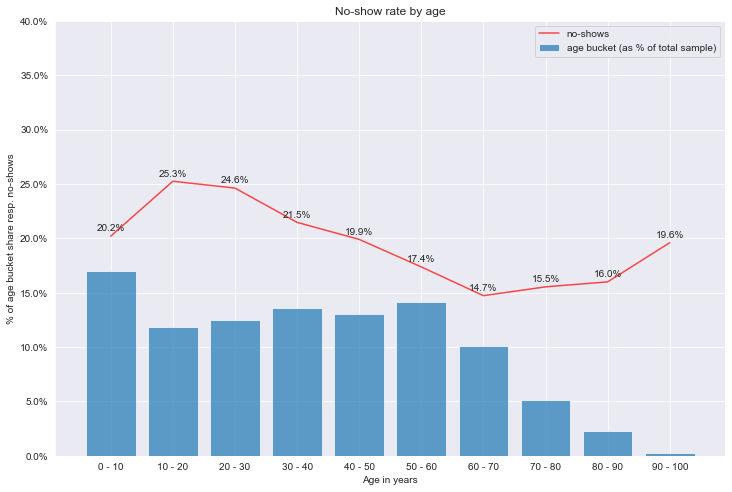

In [18]:
idx_age=np.arange(len(df_age))
plt.subplots(figsize=(12,8))
bars_age=plt.bar(idx_age, df_age['age_p'], label='age bucket (as % of total sample)', alpha=.7)
line_ns=plt.plot(idx_age, df_age['noshow'], label='no-shows', c='r', alpha=.7)
line_ns_help=plt.bar(idx_age, df_age['noshow'],  alpha=0)
plt.xticks(idx_age, age_label)
plt.ylim(0, 0.4)
plt.title('No-show rate by age')
plt.xlabel('Age in years')
plt.ylabel('% of age bucket share resp. no-shows')
plt.legend()
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
autolabel(line_ns_help)

plt.show()

#### 3.1.5. Conclusion of personal attributes:
- The average share of no-shows is 20.2%
- With a no-show rate of 20.0% and 20.3% for men resp. women, there is only a marginal difference between genders
- Social welfare recipients of _Bolsa Família_ have with 23.7% a higher rate of no-shows than non-recipients (19.8%)
- Considering age, we can see that starting from teenagers (no-show rate of 25.3%), the no-show rate decreases with age until the age bucket of 60-70 (14.7%)
- In the subsequent age buckets the no-show rate increases to up to 19.6% 

### 3.2. How do sicknesses affect no-shows?
#### 3.2.1. Data Analysis of sicknesses

The sample includes variables for 4 sicknesses: 
- Hipertension (0 or 1)
- Diabetes (0 or 1)
- Alcoholism (0 or 1)
- Disability (_Handcap_ in dataset, no further explanation; integer between 0 and 4)

To start with we will get an understanding of sicknesses in sample: % of sample with at least one sickness:

In [19]:
df_sick=df[{'hipertension', 'diabetes', 'alcoholism', 'handcap'}]
p_sick = df_sick.any(axis=1).sum()/len(df_sick)
print('{:.2%} of the sample have at least 1 sickness'.format(p_sick))

23.90% of the sample have at least 1 sickness


Calculate percentage of sample with respective sickness and plot:

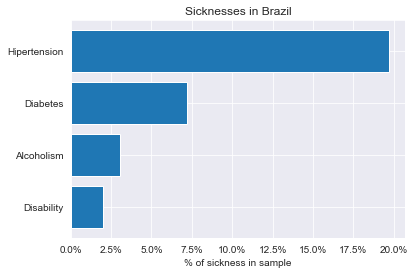

In [20]:
p_hi = df.query('hipertension == 1')['patient_id'].count() / len(df)
p_di = df.query('diabetes == 1')['patient_id'].count() / len(df)
p_al = df.query('alcoholism == 1')['patient_id'].count() / len(df)
p_ha = df.query('handcap >= 1')['patient_id'].count() / len(df)

p_sick=(p_hi, p_di, p_al, p_ha)

labels_sick=['Hipertension', 'Diabetes', 'Alcoholism', 'Disability']
idx_sick=np.arange(len(labels_sick))

barh_sick = plt.barh(idx_sick, p_sick)
plt.yticks(idx_sick, labels_sick)
plt.gca().invert_yaxis()
plt.xlabel('% of sickness in sample')
plt.title('Sicknesses in Brazil')

plt.gca().xaxis.set_major_formatter(PercentFormatter(1));

Calculate average no-shows for each sickness and variable (positive or negative):

In [21]:
p_ns_hi_y = 1-df.query('hipertension == 1')['show'].mean()
p_ns_hi_n = 1-df.query('hipertension == 0')['show'].mean()

p_ns_di_y = 1-df.query('diabetes == 1')['show'].mean()
p_ns_di_n = 1-df.query('diabetes == 0')['show'].mean()

p_ns_al_y = 1-df.query('alcoholism == 1')['show'].mean()
p_ns_al_n = 1-df.query('alcoholism == 0')['show'].mean()

p_ns_ha_y = 1-df.query('handcap >= 1')['show'].mean()
p_ns_ha_n = 1-df.query('handcap == 0')['show'].mean()

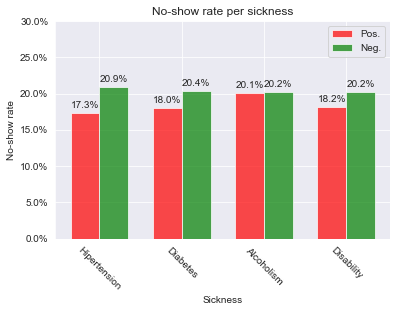

In [22]:
sick_pos=[p_ns_hi_y, p_ns_di_y, p_ns_al_y, p_ns_ha_y]
sick_neg=[p_ns_hi_n, p_ns_di_n, p_ns_al_n, p_ns_ha_n]
sick_p=[p_hi, p_di, p_al, p_ha]

width=.35
label_loc = idx_sick+width/2

bar_pos = plt.bar(idx_sick, sick_pos, width=width, color='r', alpha=.7, label='Pos.')
bar_neg = plt.bar(idx_sick+width, sick_neg, width=width, color='g', alpha=.7, label='Neg.')


plt.xticks(label_loc, labels_sick, rotation='315')
plt.legend()
plt.ylim(0, 0.3)
plt.title('No-show rate per sickness')
plt.ylabel('No-show rate')
plt.xlabel('Sickness')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
autolabel(bar_pos)
autolabel(bar_neg)

Difference of no-shows between positive and negative values in percentage points:

In [23]:
sick_delt_arr=[]
for a, x in enumerate(sick_pos):
    sick_delt_arr.append(sick_pos[a] - sick_neg[a])
    print(labels_sick[a]+' Delta Pos - Neg: '+str((sick_delt_arr[a]*100).round(2))+' pp')

Hipertension Delta Pos - Neg: -3.6 pp
Diabetes Delta Pos - Neg: -2.36 pp
Alcoholism Delta Pos - Neg: -0.05 pp
Disability Delta Pos - Neg: -2.07 pp


#### 3.2.2. Conclusion of sicknesses:
- 23.9% of population have at least 1 sickness
- Hipertension is with nearly 20% the most common sickness in the sample; diabetes, alcoholism and disability with 1-digit prevalence
- We can see that people with respective sickness have a lower share of no-shows
    - E.g. people with hipertension have with 17.3% a lower no-show rate by 3.6 pp.

### 3.3. How do pre-scheduling (date between schedule and appointment) and SMS reminders affect no-shows? 

#### 3.3.1. Pre-scheduling

In [24]:
df['date_delta'].nunique()

131

As there are 131 unique date deltas, we will group deltas: 
- Distinct buckets for date deltas <= 30 days
- 1 bucket for deltas > 30 days






In [25]:
df['delta_group'] = np.where(df['date_delta'].dt.days > 30, 31, df['date_delta'].dt.days)

Create new DataFrame with grouped date delta as index, number of appointments per bucket (count) and average show-rate (mean)

In [26]:
df_delta = df.groupby('delta_group')['show'].agg(['mean', 'count'])

Save index (date delta) as integer 

In [27]:
df_delta['delta'] = df_delta.index
df_delta.rename(index= lambda x: int(x), inplace=True)

Drop date deltas < 0 days

Calculate count as % of total count and average no-show-rate

In [28]:
df_delta.drop(df_delta.query('delta <0').index, inplace=True)
df_delta['ns_r']=1-df_delta['mean']
df_delta['delta_p']=df_delta['count']/df_delta['count'].sum()
df_delta.head()

,mean,count,delta,ns_r,delta_p
delta_group,,,,,
0,0.953531,38563,0,0.046469,0.348917
1,0.786495,5213,1,0.213505,0.047167
2,0.761784,6725,2,0.238216,0.060848
3,0.764706,2737,3,0.235294,0.024764
4,0.767297,5290,4,0.232703,0.047864


Create labels for chart based on index, rename last bucket from _31_ to _> 30_

In [29]:
delta_list=[]
for x, a in enumerate(df_delta.index):
    delta_list.append(str(x))

delta_list[31] = '> 30'

Plot data:

In [30]:
# above function adjusted to show only every 2nd data label

def autolabel_adj(rects):
    for rect in rects[::2]:
        height = rect.get_height()
        plt.annotate('{:.1%}'.format(height.round(3)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 7),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

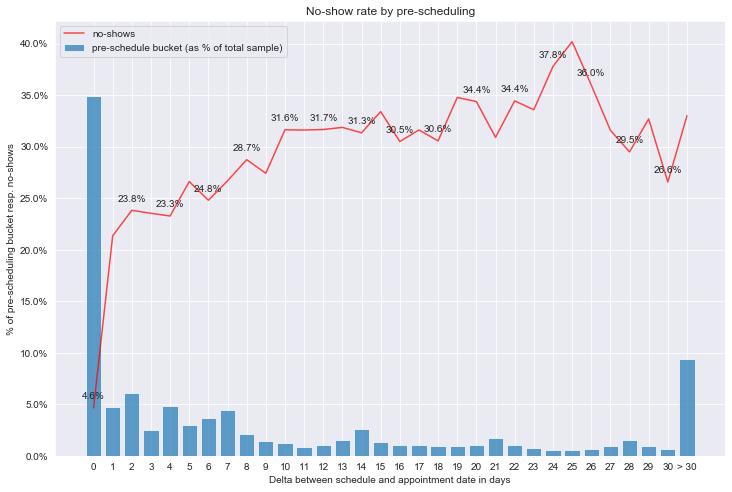

In [31]:
plt.subplots(figsize=(12,8))
idx_delta=np.arange(len(delta_list))
bar_delta=plt.bar(idx_delta, df_delta['delta_p'], label='pre-schedule bucket (as % of total sample)', alpha=.7)
line_ns=plt.plot(idx_delta, df_delta['ns_r'], label='no-shows', c='r', alpha=.7)
bar_help=plt.bar(idx_delta, df_delta['ns_r'], alpha=0)
plt.xticks(idx_delta, delta_list)
#plt.ylim(0, 0.5)
plt.title('No-show rate by pre-scheduling')
plt.xlabel('Delta between schedule and appointment date in days')
plt.ylabel('% of pre-scheduling bucket resp. no-shows')
plt.legend()
autolabel_adj(bar_help)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show();

#### 3.3.2. SMS reminder:

In [32]:
df.query('sms == 1')['date_delta'].min()

Timedelta('3 days 00:00:00')

As shown above, around 35% of appointments are scheduled the same day. Further, we can see that the minimun date delta for which an SMS reminder was sent is 3 days. Therefore, we will assume that reminders are only sent for date deltas >= 3 days and exclude date deltas < 3 days from calculating no-show rates

In [33]:
p_sms_sent = df.query('date_delta.dt.days >= 3')['sms'].mean()
p_sms_y_ns = 1-df.query('(sms == 1) & (date_delta.dt.days >= 3)')['show'].mean()
p_sms_n_ns = 1-df.query('(sms == 0) & (date_delta.dt.days >= 3)')['show'].mean()
p_sms_delta = (p_sms_y_ns - p_sms_n_ns)*100

print('SMS were sent for {:.2%} of appointments scheduled 3 days or more in advance\n \
% no-show for appointments with SMS reminder: {:.2%} \n \
% no-show for appointments without SMS reminder: {:.2%} \n \
Delta: {} pp.'.format(p_sms_sent, p_sms_y_ns, p_sms_n_ns, p_sms_delta.round(2)))

SMS were sent for 59.12% of appointments scheduled 3 days or more in advance
 % no-show for appointments with SMS reminder: 27.57% 
 % no-show for appointments without SMS reminder: 32.69% 
 Delta: -5.12 pp.


#### 3.3.3. SMS reminder and pre-scheduling:

In the next step, we will see how the no-show rate of pre-scheduled appointments will vary if we consider SMS reminders.

Create DataFrames:

In [34]:
df_delta_sms_y = 1-df.query('(sms == 1) & (date_delta.dt.days >=3)').groupby('delta_group')['show'].mean()
df_delta_sms_n = 1-df.query('(sms == 0) & (date_delta.dt.days >=3)').groupby('delta_group')['show'].mean()

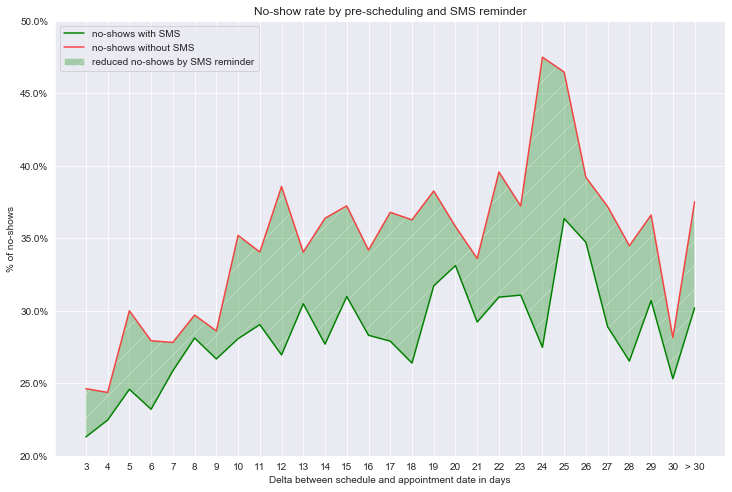

In [35]:
plt.subplots(figsize=(12,8))

line_sms_y=plt.plot(idx_delta[3:], df_delta_sms_y, label='no-shows with SMS', c='g', alpha=1)
line_sms_n=plt.plot(idx_delta[3:], df_delta_sms_n, label='no-shows without SMS', c='r', alpha=.7)
#line_sms_both=plt.plot(idx_delta[3:], df_delta['ns_r'][3:], label='no-shows combined', alpha=.7)
fills=plt.fill_between(idx_delta[3:], df_delta_sms_y, df_delta_sms_n, facecolor='g', hatch="/", \
                       label='reduced no-shows by SMS reminder', alpha=.3)
plt.xticks(idx_delta[3:], delta_list[3:])

plt.title('No-show rate by pre-scheduling and SMS reminder')
plt.xlabel('Delta between schedule and appointment date in days')
plt.ylabel('% of no-shows')
plt.legend()
plt.ylim(0.2, 0.5)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show();

In [36]:
max_delta=((df_delta_sms_y-df_delta_sms_n).min())*100
print('Max delta in pre-scheduling buckets: {} pp'.format(max_delta.round(2)))

Max delta in pre-scheduling buckets: -20.02 pp


#### 3.3.4. Conclusion of pre-scheduling and SMS reminder:
- Around 35% of appointments are scheduled same day, which on the same time has the lowest no-show rate (<5%)
- On average, the no-show rate increases the longer the appointment is scheduled in the future
- SMS reminder were sent for c.60% of observations that were scheduled 3 days or more in advance
- Compared to observations without SMS reminders, the no-show rate of observations with reminders is 5.1 pp lower
- Combining SMS reminders and pre-scheduling, we can see that SMS reminders can reduce no-shows by up to 20 pp

<a id='conclusions'></a>
## 4. Conclusions

- The project analyzed 110,527 observations of medical appointments in Brazil
- No-shows were analyzed based on 3 categories:
    - Personal attributes (gender, scholarship [Bolsa Família], age)
    - Sicknesses (hipertension, diabetes, alcoholism, disability)
    - Pre-scheduling and SMS notifications




### 4.1. Personal attributes
- It was shown that gender has a marginal impact on no-shows, with women having a higher no-show rate of 0.3 pp compared to men
- Social welfare recipients of Bolsa Família have with 23.7% a higher rate of no-shows than non-recipients (19.8%)
- Starting from teenagers (10-20 years; 25.3% no-shows), the no-show rate decreases with age until the age of 60-70 years (14.7% no shows), thereafter increasing by age up to 19.6% for the age bucket 90-100 years

### 4.2. Sicknesses
- While 23.9% of the sample have at least 1 sickness, hipertension is the most common with nearly 20%
- All sicknesses have a positive impact on no-shows, meaning that people with any sickness tend to have a lower no-show rate 
- The difference varies between 0.1 pp (alcoholism) and 3.6 pp (hipertension)

### 4.3. Pre-scheduling and SMS notifications
- 35% of appointments are scheduled the same day and have comparably a low no-show rate of 4.6%
- In general, the no-show rate increases with pre-scheduling, meaning that appointments that are scheduled further in the future, tend to have a higher no-show rate
- SMS notifications were sent for nearly 60% of appointments scheduled 3 days or more in the future
- Considering these pre-scheduled appointments, ones with SMS notification have a lower no-show rate by more than  5 pp
- Combining pre-scheduling and SMS notifications, we can see that reminders can reduce no-shows by up to 20 pp